
# Preambule:

Je vais ici procéder à une analyse des URL pour définir s'il s'agit d'une URL suspecte (spam) ou non. J'ai utilisé plusieurs caractéristiques de ces URL à ma disposition, mais les caractéristiques explorées ne sont pas exhaustives.

In [35]:
import re
import threading
import requests
from typing import Optional, List, Dict
from datetime import datetime
from urllib.parse import urlparse
from loguru import logger
import numpy as np
from bs4 import BeautifulSoup
from spellchecker import SpellChecker
import textdistance
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import PolynomialFeatures
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn.objects as so

# Nettoyage et création des caractéristiques du dataset
* Importation du dataset
* Analyse des premières lignes

In [36]:
csv_path = Path.cwd().parent / 'dataset.csv'
df_base = pd.read_csv(csv_path)
df_base.head(5)

,domain,label
0,http://sprint.com/business/solutions/mobility_...,0.0
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0.0
2,http://web.de/magazine/digital/sicher-im-netz/...,0.0
3,www.wired.com/science/discoveries/news/1999/08...,0.0
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1.0


On s'aperçoit immédiatement que le dataset est déséquilibré.

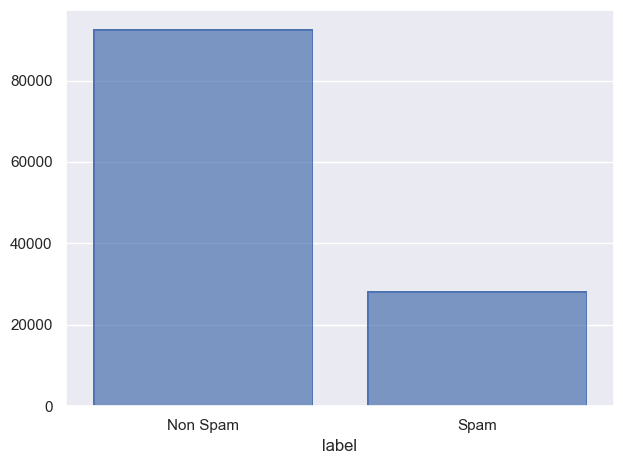

In [37]:
df_base['label'] = df_base['label'].replace({0: 'Non Spam', 1: 'Spam'})
graph = so.Plot(df_base, x="label").add(so.Bar(), so.Count(), so.Dodge())
graph.show()

# Nettoyage
L'information de l'URL ne peut pas être utilisée de manière brute. Pour nettoyer mon dataset, je vais utiliser deux class distinctes qui prennent en argument une URL.

* La première classe nettoie l'URL.
* La seconde, qui hérite de la première, crée de nouvelles caractéristiques.

Cette approche orientée ligne (j'aurais pu choisir une approche orientée colonne) est plus adaptée ici, car elle me permettra de paralléliser le nettoyage et d'augmenter la rapidité du processus compte tenu de la taille du dataset.

Les informations essentielles à isoler sont : le nom de domaine, l'extension (par exemple .com), le chemin du site et enfin les paramètres.

Certaines informations ne sont pas présentes dans certains cas ; la fonction retourne alors None.

In [38]:
class InformationUrl():
    def __init__(self, full_url: str, y: bool):

        self.full_url = full_url
        self.domain: Optional[str] = self.get_domain_name() # Get domain name from full URL
        self.extension: Optional[str] = self.get_extension()  # Get extension from full URL
        self.path: Optional[str] = self.get_path() # Get path from full URL
        self.query: Optional[str] = self.get_query() # Get query string from full URL
        self.is_fishing = y # Assign value to is_fishing variable

    def get_domain_name(self) -> Optional[str]:
        """
        Extracts the domain name from the full URL.

        Returns:
            str or None: The domain name extracted from the URL, or None if no valid domain name is found.
        """
        url = self.full_url
        if not self.full_url.startswith('http'):
            url = 'http://' + url
        parsed_url = urlparse(url)
        domain = parsed_url.netloc

        if domain.startswith('www.'):
            domain = domain[4:]

        if domain == '':
            logger.warning(f'{self.full_url} has nos no valid domaine name.')
            domain = None

        return domain

    def get_extension(self) -> Optional[str]:

        """
        Extracts the extension from the domain name of the URL.

        Returns:
            str or None: The extension extracted from the domain name, or None if no valid extension is found.
        """

        if self.domain is None:
            return None

        elif '.' not in self.domain:
            logger.warning(f'{self.full_url} has nos no valid extension.')
            return None
        else:
            domain_extension = self.domain.split('.')[-1]
            return domain_extension

    def get_path(self) -> Optional[str]:
        """
        Extracts the path from the URL.

        Returns:
            str or None: The path extracted from the URL, or None if no valid path is found.
        """

        if self.domain is None:
            return None

        parsed_url = urlparse(self.full_url)
        path = parsed_url.path

        if path != '':
            return path
        else:
            return None

    def get_query(self):
        """
        Extracts the query string from the URL.

        Returns:
            str or None: The query string extracted from the URL, or None if no valid query string is found.
        """
        if self.domain is None:
            return None

        parsed_url = urlparse(self.full_url)
        query = parsed_url.query

        if query != '':
            return query
        else:
            return None

    def __str__(self):
        return str({'domain': self.domain, 'extension': self.extension, 'path': self.path, 'query': self.query})



## Création des caractéristiques
La seconde classe crée de nouvelles caractéristiques. Après une recherche, il m'est apparu que les éléments les plus caractéristiques des spams sont : le grand nombre de noms de sous-domaine, la présence de paramètres, et la présence de caractères spécifiques comme le 'o' cyrillique au lieu du 'o' latin. Ce sont autant de caractéristiques que je vais récupérer à travers cette seconde classe.

Il m'est apparu que les sites malveillants, vers lesquels renvoient les liens, sont rarement des sites anciens. Je suis donc allé scraper le web (https://who.is/whois/) pour obtenir la date de création du site hébergé. Cette étape est particulièrement longue (environ 1.5 seconde par requête).

In [39]:

class CharacteristicURL(InformationUrl):

    def __init__(self, full_url: str,  y: bool):
        InformationUrl.__init__(self, full_url=full_url, y=y)

        '''
            A class representing characteristic information about a URL.

    Attributes:
        full_url (str): The full URL to process.
        y (bool): A boolean indicating whether the URL is associated with phishing.
        number_sub_domains (Optional[int]): The number of subdomains in the URL.
        ask_parameters_connection (bool): A boolean indicating whether the URL requests additional parameters upon connection.
        specific_characters (Optional[bool]): A boolean indicating whether the URL contains specific characters associated with phishing.
        creation_date (Optional[datetime]): The creation date of the URL.

        '''

        self.levenstein: Optional[List[int]] = None# self.get_levenstein_closest_words()
        self.number_sub_domains: Optional[int] = self.get_number_sub_domain()
        self.ask_parameters_connection: bool = self.is_request()
        self.specific_characters: Optional[bool] = self.is_specific_character()
        self.creation_date: Optional[datetime] = self.get_creation_date()

    def is_request(self) -> Optional[bool]:

        """
        Checks if the URL requests additional parameters upon connection.

        Returns:
            bool or None: True if additional parameters are requested, False otherwise. None if the URL is invalid.
        """

        if '?' in self.full_url:
            return True
        else: return False

    def is_specific_character(self) -> Optional[bool]:
        """
        Checks if the URL path contains specific characters associated with phishing.

        Returns:
            bool or None: True if the URL path contains specific characters, False otherwise. None if the URL path is None.
        """
        if self.path is None:
            return None
        if re.search(r'[\u0080-\uFFFF]', self.path):
            return True
        else:
            return False

    def get_number_sub_domain(self) -> Optional[int]:

        """
        Calculates the number of subdomains in the URL.

        Returns:
            int or None: The number of subdomains in the URL if the domain is not None, otherwise None.
        """

        if self.domain is not None:
            return len(self.domain.split('.'))
        else:
            return 0

    def get_levenstein_closest_words(self)-> Optional[List[float]]:

        if self.path is None:
            return None

        separation_char = './_+%\-'
        words = [word for word in re.split(rf'[{separation_char}]', self.path)]
        words = [word for word in words if len(word) > 3 and not re.search(r'\d', word)]

        spell = SpellChecker()

        best_words = [spell.correction(word) for word in words]

        levensteins = [1 - textdistance.levenshtein.distance(word, best_word)/len(best_word) if best_word is not None else 0 for word, best_word in zip(words, best_words)]

        return levensteins

    def get_creation_date(self) -> Optional[datetime]:

        """
        Retrieves the creation date of the domain from a WHOIS lookup.

        Returns:
            datetime or None: The creation date of the domain if available, otherwise None.
        """

        if self.domain is None:
            return None

        separation_char = '.'
        words = [word for word in re.split(rf'[{separation_char}]', self.domain)]
        valid_url = '.'.join(words[:2])
        if len(valid_url.split('.')) == 2:
            url = 'https://who.is/whois/' + valid_url
        else:
            return None

        response = requests.get(url)
        html_content = response.text

        soup = BeautifulSoup(html_content, 'html.parser')

        balise_div_registered_on = soup.find('div', class_='col-md-4 queryResponseBodyKey', string='Registered On')
        if balise_div_registered_on is None:
            return None
        balise_suivante = balise_div_registered_on.find_next_sibling('div')
        date_creation_str = balise_suivante.get_text()

        if date_creation_str == '':
            return None
        else:
            return datetime.strptime(date_creation_str, "%Y-%m-%d")

    def get_values(self) -> Dict:

        """
        Returns a dictionary containing various characteristics of the URL.

        Returns:
            dict: A dictionary containing the domain, extension, path, query string, parameters connection status,
            presence of specific characters, creation date, number of subdomains, Levenshtein distances, and phishing status.
        """

        return {"domain": self.domain, "extension": self.extension, "path": self.path, "query": self.query,
         "parameters": self.ask_parameters_connection, "specific_characters": self.specific_characters,
         "creation_date": self.creation_date, "sub_domain": self.number_sub_domains,
         "y": self.is_fishing}

    def __str__(self):
        return str({"domain": [self.domain], "extension": [self.extension], "path": [self.path], "query": [self.query], "parameters": [self.ask_parameters_connection], "specific_characters": [self.specific_characters], "creation_date": [self.creation_date], "sub_domain": [self.number_sub_domains], "levenstein": [self.levenstein], "y": [self.is_fishing]})


Pour réaliser ce processus de nettoyage et création, je parallélise le processus avec du multithreading. Chaque thread effectue sa partie et vient enregistrer son résultat dans un dataframe final qui sera fusionné. Sans cette partie, il me faudrait environ 1 jour pour scraper toutes les dates de création des sites web.  
A noter que j'ai équilibré mon dataset.    
J'ai délibérément choisi de ne pas l'augmenter car j'ai suffisamment de données d'une part, et l'augmentation des adresses de label 1 serait pauvre et n'apporterait pas beaucoup à l'analyse. J'ai donc choisi de ne pas mettre tous les labels 0.

In [40]:
def create_df_characteristics(df: pd.DataFrame, thread_number: int):

    '''
    Create DataFrame with URL characteristics.

    Args:
        df (pd.DataFrame): DataFrame containing URLs and labels.
        thread_number (int): Thread number for progress tracking.
    '''


    global df_thread
    columns = CharacteristicURL(df['domain'].iloc[0], False)
    columns = list(columns.get_values().keys())

    df_urls = pd.DataFrame(columns=columns)
    for index, row in tqdm(df.iterrows(), desc=f'Thread {thread_number}'):
        url_name = row['domain']
        label = row['label']
        url_characteristic = CharacteristicURL(url_name, label)
        df_urls.loc[index] = url_characteristic.get_values()

    df_thread.append(df_urls)



def run_thread_create_df_characteristics(df: pd.DataFrame, thread_number: int) -> pd.DataFrame:

    '''
    Run multiple threads to create DataFrame with URL characteristics.

    Args:
        df (pd.DataFrame): DataFrame containing URLs and labels.
        thread_number (int): Number of threads to use.

    Returns:
        pd.DataFrame: DataFrame with URL characteristics.
    '''

    number_line_y_egal_1 = (df['label'] == 1).sum()
    df = pd.concat([df.loc[df['label'] == 1].head(number_line_y_egal_1), df.loc[df['label'] == 0].head(number_line_y_egal_1)])
    logger.info(f'among the {len(df)}, {2*number_line_y_egal_1} selected to have a balance dataset')
    parts = np.array_split(df, thread_number)
    global df_thread
    df_thread = []
    threads = []
    # Afficher les cinq parties
    for i, part in enumerate(parts):
        thread = threading.Thread(target=create_df_characteristics, args=(part, i))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    return pd.concat(df_thread, axis=0)


Voici le code pour initialiser le nettoyage du dataset. Les commentaires servent à éviter de relancer ce processus qui dure tout de même environ 20 minutes. Pour des raisons pratiques, j'ai sauvegardé les résultats du nouveau dataset au format CSV.

In [41]:
csv_path = Path.cwd().parent / 'dataset.csv'
df = pd.read_csv(csv_path)
#df_save = run_thread_create_df_characteristics(df.head(2000), 40)
# df_save.to_csv('new_dataset.csv', index=False)

On analyser ici le résultat final

In [42]:
csv_path = Path('new_dataset.csv')
df = pd.read_csv(csv_path)
df['y'] = df['y'].replace({0: 'Non Spam', 1: 'Spam'})
df.head(5)

,domain,extension,path,query,parameters,specific_characters,creation_date,sub_domain,y
0,tobogo.net,net,/cdsb/board.php,board=qatorrent&bm=view&no=4268&category=&auth...,True,False,2017-08-06,2.0,Non Spam
1,torcache.net,net,/torrent/108BB17DBAAE5ABFADEBFC449D33D7B6889A1...,title=[kickass.to]game.of.thrones.s05e01.e02.e...,True,False,2011-04-29,2.0,Non Spam
2,linguee.fr,fr,linguee.fr,NaN,False,False,NaN,2.0,Non Spam
3,smithsonianeducation.org,org,www.smithsonianeducation.org/textiles/index.htm,NaN,False,False,2003-01-29,2.0,Non Spam
4,dol.gov,gov,www.dol.gov/oasam/programs/osdbu/,NaN,False,False,1997-10-02,2.0,Non Spam


Le dataset est parfaitement équilibré.

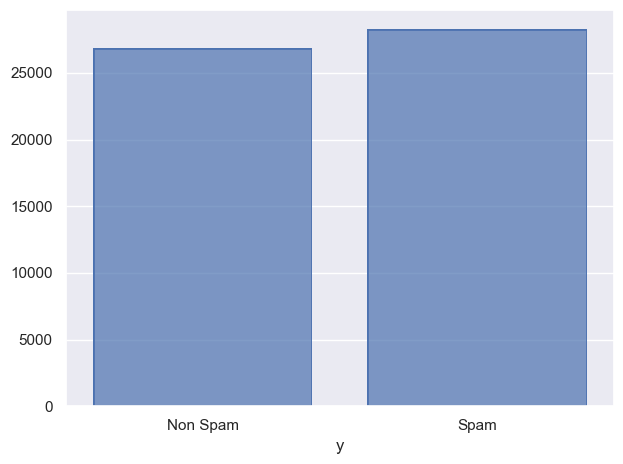

In [8]:
graph = so.Plot(df, x="y").add(so.Bar(), so.Count(), so.Dodge())
graph.show()

# Data visualisation
Je vais maintenant mener une série d'analyses visuelles sur les nouvelles caractéristiques obtenues.

## Présence de paramètres
On s'aperçoit ici que les URL qui demandent des paramètres de connexion ont plus tendance à être des spams. Ce n'est pas automatique, mais c'est une tendance.

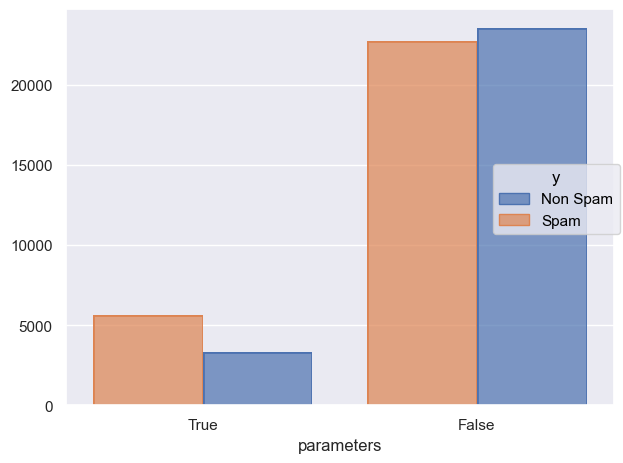

In [43]:
graph = so.Plot(df, x="parameters",color="y").add(so.Bar(), so.Count(), so.Dodge())
graph.show()

## Présence de caractères spécifiques

Contre toute attente, dans mon dataset, aucune URL ne contient de caractère trompeur. Je n'utiliserai donc pas cette caractéristique.

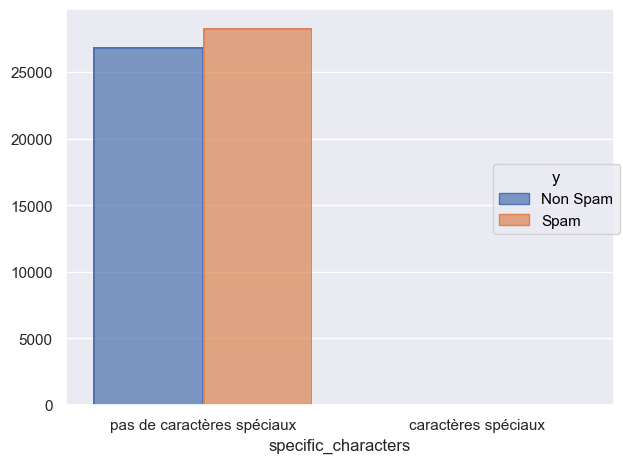

In [44]:
df['specific_characters'] = df['specific_characters'].replace({0: 'pas de caractères spéciaux', 1: 'caractères spéciaux'})
graph = so.Plot(df, x="specific_characters",color="y").add(so.Bar(), so.Count(), so.Dodge())
graph.show()

## Analyse de la date de création

On s'aperçoit immédiatement que les adresses utilisées pour le fishing ont une tendance à être de nouvelles adresses créées pour l'occasion. Une adresse récente pourrait donc indiquer une adresse potentiellement suspecte.

C:\Users\baran\AppData\Local\Temp\ipykernel_27108\4087087513.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['creation_date'].fillna('2024-04-01', inplace=True)


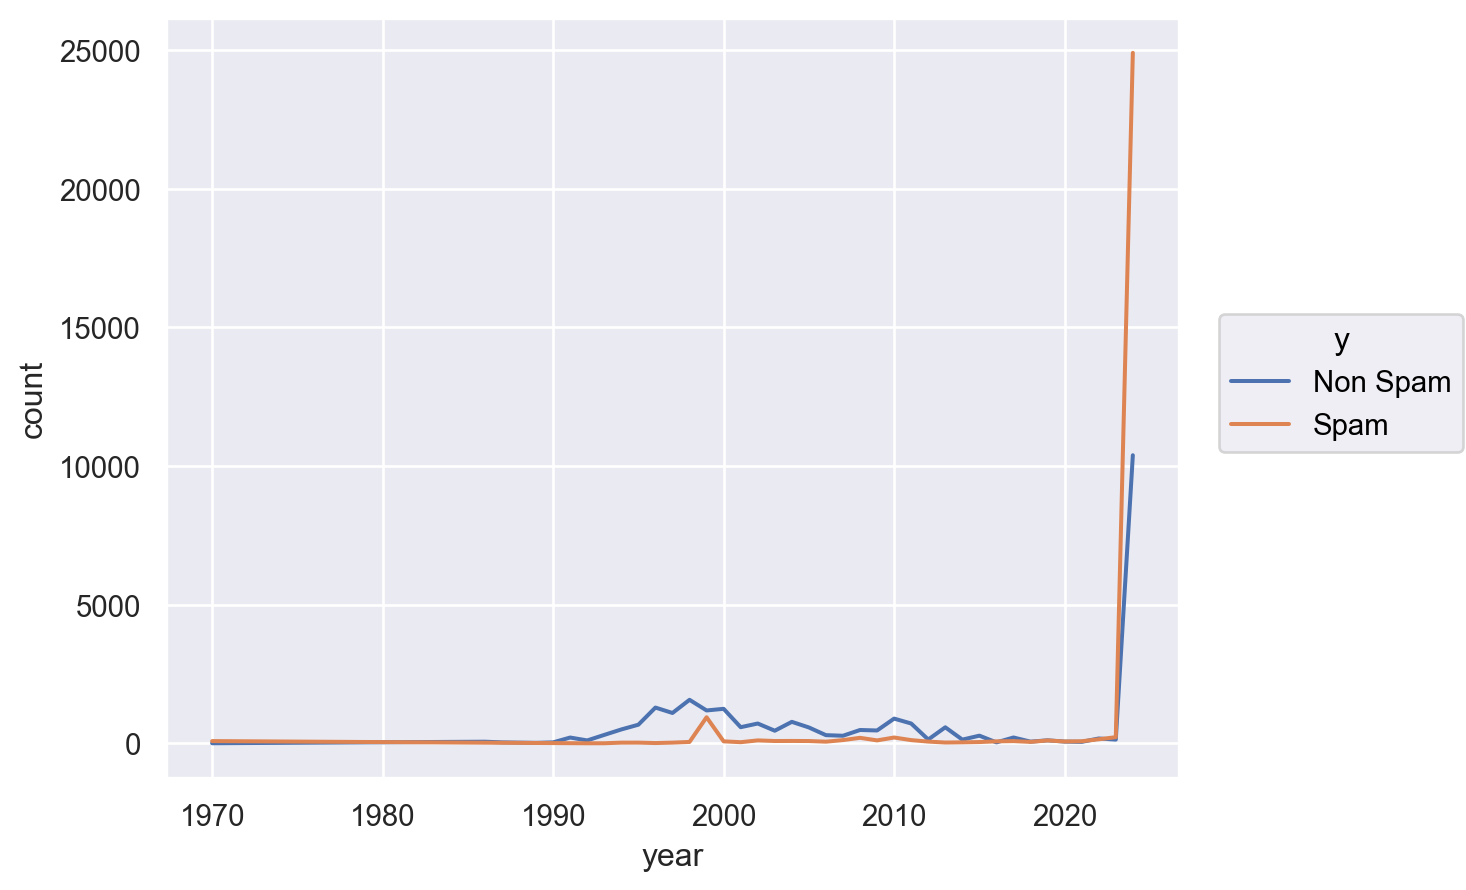

In [45]:
df['creation_date'].fillna('2024-04-01', inplace=True)
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['year'] = df['creation_date'].dt.year
df_aggregated = df.groupby(['year', 'y']).size().reset_index(name='count')
p = so.Plot(df_aggregated, "year", "count", color="y")
p.add(so.Line(), so.Agg())


# Entraînement des modèles

J'entraîne chaque modèle sur le nouveau fichier CSV que je charge. 

Je vais diviser mon dataset en deux parties : une pour l'entraînement de mes modèles intermédiaires et une autre pour l'entraînement de mon modèle final

##  Nombre de domaines
Ici, j'entraîne un modèle de régression logistique pour obtenir une valeur de seuil à partir de laquelle une URL est suspecte en fonction de son nombre de domaines. Avec un F1-score de 66% pour le label 0, on peut considérer que cette information est une indication, mais ne sera pas décisive dans mon analyse.

In [46]:

csv_path = Path('new_dataset.csv')
df = pd.read_csv(csv_path)
df['sub_domain'].fillna(0, inplace=True)

df['creation_date'].fillna('2024-04-01', inplace=True)
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['month'] = df['creation_date'].dt.month
df['year'] = df['creation_date'].dt.year


df = df.sample(frac=1, random_state=42)  # mix dataset


df_modele_intermediaire = df.iloc[:len(df)//2] # split in 2
df_modele_final = df.iloc[len(df)//2:] # split in 2

C:\Users\baran\AppData\Local\Temp\ipykernel_27108\1028947717.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sub_domain'].fillna(0, inplace=True)
C:\Users\baran\AppData\Local\Temp\ipykernel_27108\1028947717.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

In [47]:

X = df_modele_intermediaire[['sub_domain']]
y = df_modele_intermediaire['y']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_sub_domain = LogisticRegression()

model_sub_domain.fit(X_train.values, y_train.values)

# Prédiction sur l'ensemble de test
y_pred = model_sub_domain.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.6035138561854736
              precision    recall  f1-score   support

         0.0       0.57      0.75      0.65      2689
         1.0       0.66      0.46      0.54      2832

    accuracy                           0.60      5521
   macro avg       0.62      0.61      0.60      5521
weighted avg       0.62      0.60      0.60      5521



##  Date de création du domaine
J'utilise le même type de modèle (Regression logistic) idéal pour repérer les seuils, comme constaté dans le graphique correspondant ci-dessus. Avec des scores F1 proches de 70% et 80% pour le label, on s'aperçoit que la date de création est un élément beaucoup plus fiable pour mesurer si une adresse est suspecte.

In [48]:

X = df_modele_intermediaire[['month', 'year']]
y = df_modele_intermediaire['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_date = LogisticRegression()
model_date.fit(X_train.values, y_train.values)

y_pred = model_date.predict(X_test.values)

accuracy = accuracy_score(y_test.values, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.761999637746785
              precision    recall  f1-score   support

         0.0       0.87      0.61      0.71      2689
         1.0       0.71      0.91      0.80      2832

    accuracy                           0.76      5521
   macro avg       0.79      0.76      0.75      5521
weighted avg       0.78      0.76      0.76      5521



## Analyse de fréquence des mots clefs

Je vais maintenant analyser les mots employés dans l'URL. Le réseau ci-dessous est un simple modèle connecté Torch pour analyser en fonction des mots employés (parmi 500 identifiés) si oui ou non l'adresse est suspecte.

In [49]:

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(500, 100) 
        self.fc2 = nn.Linear(100, 1)   
        self.relu = nn.ReLU()          
        self.sigmoid = nn.Sigmoid()    
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x.squeeze(1)



Pour cela, je vais utiliser le module TfidfVectorizer de scikit-learn pour vectoriser le texte de chaque URL.

* Le texte utilisé ne concerne que l'extension et le chemin (la requête aurait pu être ajoutée). Le nom de domaine n'a pas été utilisé car je ne peux pas le segmenter en mots distincts automatiquement, ou même simplement sur cette partie.
* Les textes ont été nettoyés de tous les caractères spéciaux et remplacés par des espaces pour utiliser l'algorithme.
* J'utilise simplement les 500 mots avec la fréquence la plus élevée pour classifier une URL.
* Je n'entraîne la vectorisation que sur les données du train dataset.

In [50]:
def create_matrice_text_url(df: pd.DataFrame):

    """
    This function takes a DataFrame containing text data and their corresponding labels, 
    preprocesses the text data, calculates TF-IDF features, and splits the data into 
    training and testing sets. It then converts the data into tensors and returns 
    the training and testing data ready for model training.

    Parameters:
    - df: DataFrame, containing 'text', 'label', 'extension', and 'path' columns.

    Returns:
    - x_train: Tensor, TF-IDF features of the training data.
    - y_train: Tensor, labels of the training data.
    - x_test: Tensor, TF-IDF features of the testing data.
    - y_test: Tensor, labels of the testing data.
    """

    df_text_analyse = pd.DataFrame(columns=['text', 'label'])
    for index, row in tqdm(df.iterrows()):
        extension = row['extension']
        path = row['path']
        full_text = f'{extension} {path}'
        separation_char = './_+%\-'
        words = [word for word in re.split(rf'[{separation_char}]', full_text)]
        full_text = (' ').join(words)
        label = row['y']
        df_text_analyse.loc[index] = {'text': full_text, 'label': label}

    train_df, test_df = train_test_split(df_text_analyse, test_size=0.2, random_state=42)

    tfidf_vectorizer = TfidfVectorizer(max_features=500)
    # # Calcul du TF-IDF
    tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_df.text).toarray().astype('float16')
    tfidf_matrix_test = tfidf_vectorizer.transform(test_df.text).toarray().astype('float16')

    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for i in range(tfidf_matrix_train.shape[0]):
        x_train.append(torch.tensor(tfidf_matrix_train[i, :]).to(torch.float32))#.reshape(1, -1)
        y_train.append(torch.tensor(train_df.at[i, 'label']).to(torch.float32))

    for i in range(tfidf_matrix_test.shape[0]):
        x_test.append(torch.tensor(tfidf_matrix_test[i, :]).to(torch.float32)) #.reshape(1, -1)
        y_test.append(torch.tensor(test_df.at[i, 'label']).to(torch.float32))

    return torch.stack(x_train),  torch.stack(y_train), torch.stack(x_test),  torch.stack(y_test), tfidf_vectorizer




J'implémente ici la boucle d'entraînement et de validation. Je recode aussi les différentes métriques habituelles : la précision et le rappel pour les 2 labels.

In [51]:

def train(model, criterion, optimizer, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

def validate(model, criterion, val_loader):
    model.eval()
    correct = 0
    total = 0
    total_predict_label_0 = 0
    true_negatif = 0
    total_label_0 = 0
    total_label_1 = 0
    true_positive = 0

    total_predict_label_1 = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_negatif += ((predicted == labels) & (labels == 0)).sum().item()
            total_label_0 += (labels == 0).sum().item()
            total_predict_label_0 += (predicted == 0).sum().item()
            total_label_1 += (labels == 1).sum().item()
            total_predict_label_1 += (predicted == 1).sum().item()
            true_positive += ((predicted == labels) & (labels == 1)).sum().item()

    precision_label_0 = true_negatif / total_predict_label_0 * 100 if total_label_0 != 0 else 0
    precision_label_1 = true_positive / total_predict_label_1 * 100 if total_label_1 != 0 else 0
    recall_label_0 = true_negatif / total_label_0 * 100 if total_label_0 != 0 else 0
    recall_label_1 = true_positive / total_label_1 * 100 if total_label_1 != 0 else 0
    accuracy = (true_negatif + true_positive) / total
    
    print(f'Precision for label 0: {precision_label_0:.2f}%')
    print(f'Recall for label 0: {recall_label_0:.2f}%')
    print(f'Precision for label 1: {precision_label_1:.2f}%')
    print(f'Recall for label 1: {recall_label_1:.2f}%')
    print(f'Accuracy: {accuracy:.2f}%')

J'effectue un entraînement sur une dizaine d'époques (la perte ne diminue plus par la suite).

J'utilise la fonction de perte BCELoss qui est idéale pour des tâches de classification.

Adam est un optimiseur adaptatif et efficace, c'est la raison pour laquelle je l'ai choisi comme optimiseur.

Avec une précision et un rappel de 90 % pour les 2 labels, les performances du modèle sont satisfaisantes.

In [52]:

x_train, y_train , x_test, y_test, tfidf_vectorizer = create_matrice_text_url(df_modele_intermediaire)


train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


model_url = SimpleModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_url.parameters(), lr=0.001)
train(model_url, criterion, optimizer, train_loader, num_epochs=8)
validate(model_url, criterion, test_loader)

27602it [00:42, 644.79it/s]


Epoch 1/8, Loss: 0.3659836428961313
Epoch 2/8, Loss: 0.2057803252959527
Epoch 3/8, Loss: 0.19506033045519683
Epoch 4/8, Loss: 0.1913605088669527
Epoch 5/8, Loss: 0.19898222034764773
Epoch 6/8, Loss: 0.18917092056149237
Epoch 7/8, Loss: 0.18666297790004416
Epoch 8/8, Loss: 0.18599367672725542
Precision for label 0: 94.81%
Recall for label 0: 82.82%
Precision for label 1: 85.44%
Recall for label 1: 95.69%
Accuracy: 0.89%


## Entraînement du modèle final
Pour mettre en œuvre un ensemble de stacking, je vais stocker toutes mes prédictions intermédiaires dans un dataframe intermédiaire. Ensuite, j'utiliserai ce dataset pour effectuer mes predictions finales avec un modèle de boosting.   
J'utiliserai pour cela un dataset completement independant des datasets utilisées précedement.

In [54]:
df_modele_final.head(5)

,domain,extension,path,query,parameters,specific_characters,creation_date,sub_domain,y,month,year
8185,holihjrfmobilitycyprus.com,com,holihjrfmobilitycyprus.com/toate/ZUOnb/,NaN,False,False,2024-04-01,2.0,1.0,4,2024
3348,fuony-cprner.com,com,fuony-cprner.com/wp-content/plugins/akismet/44...,NaN,False,False,2024-04-01,2.0,1.0,4,2024
701,tycsapsc.com,com,www.tycsapsc.com/en/zonapublica/index.aspx,NaN,False,False,2003-05-06,2.0,0.0,5,2003
10914,paypal-doofirm.de,de,paypal-doofirm.de/31569/index.php,NaN,False,False,2024-04-01,2.0,1.0,4,2024
27971,pastehtml.com,com,pastehtml.com/wiew/cmro08kiz.html,NaN,False,False,2024-04-01,2.0,1.0,4,2024


In [55]:

df_stack = df_modele_final[['parameters', 'y']].copy()

for index, row in tqdm(df_modele_final.iterrows()):

    month = row['month']
    year =  row['year']
    prediction_date = model_date.predict([[month, year]])
    df_stack.at[index, 'prediction_date'] = prediction_date[0]

    sub_domain = row['sub_domain']
    prediction_domain = model_sub_domain.predict([[sub_domain]])
    df_stack.at[index, 'prediction_sub_domain'] = prediction_domain[0]


    extension = row['extension']
    path = row['path']
    full_text = f'{extension} {path}'
    separation_char = './_+%\-'
    words = [word for word in re.split(rf'[{separation_char}]', full_text)]
    full_text = (' ').join(words)
    tfidf_matrix_input = tfidf_vectorizer.transform([full_text]).toarray().astype('float16')
    input_tensor = torch.tensor(tfidf_matrix_input).to(torch.float32)
    model_url.eval()

    with torch.no_grad():
        prediction_url = model_url(input_tensor)
    # prediction_url = (prediction_url).item()
    prediction_url = torch.round(prediction_url).item()
    df_stack.at[index, 'prediction_url'] = prediction_url

    
    
    

27603it [00:41, 668.79it/s]


In [56]:
# df_stack['parameters'] = df_stack['parameters'].replace({True:1, False: 0})
df_stack.head(5)

,parameters,y,prediction_date,prediction_sub_domain,prediction_url
8185,False,1.0,1.0,0.0,1.0
3348,False,1.0,1.0,0.0,1.0
701,False,0.0,0.0,0.0,0.0
10914,False,1.0,1.0,0.0,1.0
27971,False,1.0,1.0,0.0,1.0


J'utilise un modèle de boosting pour classifier les URL suspectes en utilisant mes caractéristiques intermédiaires.

In [57]:


xgb_clf = XGBClassifier()

X = df_stack.drop(columns=['y']) 
y = df_stack['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy XGBoost:", accuracy_xgb)


Accuracy XGBoost: 0.9193986596631045


Bien que l'analyse de fréquence assure 90 % de l'exactitude finale, grâce à l'analyse de la présence de paramètres et à l'analyse des dates, je diminue l'erreur de 20 %, ce qui est considérable.

Les modèles de détection d'adresses frauduleuses ont une précision située entre 90 % et 99 %. Avec les 92 % de ce modèle, je considère que son exactitude est acceptable.

# Conclusion
## détection de drift

La détection de drift doit être menée pour chaque variable de manière indépendante et périodique (par exemple toutes les semaines). Indépendante, car les variables utilisées sont différentes (entiers, booléens, dates, texte), nous devons donc adapter l'approche pour chacun.

* Concernant la présence d'arguments et le nombre de sous-domaines, un test Kolmogorov-Smirnov nous permettra de détecter si la distribution est la même d'une période sur l'autre.

* L'approche est similaire pour la détection de texte. Je propose de vérifier si la fréquence d'apparition des mots clés est similaire.

* Concernant la date, le drift est inévitable et il sera nécessaire de mettre à jour les informations régulièrement. Les sites fiables restent anciens, mais de nouveaux sites qui hébergent des url suspectes, apparaissent ou disparaissent chaque jour. Les informations doivent donc être régulièrement mises à jour.

## Surveiller les performances

Le nombre de spams étant beaucoup plus faible que le nombre de courriels valides (ce qui n'était pas le cas dans mon analyse car j'ai utilisé un ensemble de données équilibré pour entraîner mon modèle), je pense qu'il est crucial de surveiller :
* le rappel des étiquettes de spam pour garantir que le modèle les détecte toujours tous (le risque étant que les stratégies évoluent). Les liens valides ont a priori moins de raisons de changer au fil du temps.
* Il faudra également rester vigilant sur la précision de la détection des courriels valides pour s'assurer qu'une nouvelle stratégie ne contourne pas la méthode que j'ai développée. Dans ce cas, la précision de détection des courriels valides pourrait diminuer.

À noter que cette approche doit être réalisée sur le modèle final, mais aussi sur les modèles intermédiaires pour détecter une modification locale des performances.


## Ajout de nouvelles caractéristiques
Dans un vrai projet, ma classe pour créer de nouvelles caractéristiques n'aurait pas été codée en fonction (comme je l'ai fait dans la class CharacteristicURL), mais chaque fonction serait une classe indépendante qui hériterait d'une classe générale (classe d'abstraction).

L'intérêt est de pouvoir facilement intégrer une nouvelle caractéristique dans le pipeline (elle prendrait les mêmes entrées et fournirait les mêmes sorties). Cette class de caractéristique pourrait éventuellement intégrer son propre modèle de prédiction. L'objectif serait de soumettre au modèle final une liste d'inputs de type classe qui hérite de CaracteristiqueURL.
 On pourrait ainsi très simplement ajouter ou enlever l'analyse ou l'utilisation d'une ou plusieurs caractéristiques en modifiant la liste d'instance de CaracteristiqueURL que l'on fournirait en input du modèle final.
 Il s'agirait typiquement d'une approche SOLID.

Dans ce notebook, ce n'est pas l'approche utilisée, car je me trouve davantage dans le cadre d'un POC que dans la mise en production d'un logiciel (l'approche SOLID est très efficace mais demande un peu plus de temps de développement).